In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.getcwd()
os.chdir("/content/drive/MyDrive/Mini_PersonalizationOfInformation")

In [3]:
# ! pip install -r requirements.txt

In [4]:
# !pip install spektral.layers

In [5]:
# ! pip install stellargraph

In [23]:
import numpy as np
import os
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GraphConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import stellargraph as sg

In [8]:
all_data = []
all_edges = []

with open('cora/cora.content','r') as f:
  all_data.extend(f.read().splitlines())
with open('cora/cora.cites','r') as f:
  all_edges.extend(f.read().splitlines())          
#Shuffle the data because the raw data is ordered based on the label
random_state = 77
all_data = shuffle(all_data,random_state=random_state)

In [9]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Case_Based', 'Genetic_Algorithms', 'Rule_Learning', 'Neural_Networks', 'Theory', 'Probabilistic_Methods', 'Reinforcement_Learning'}

Number of classes:  7


In [10]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


train_idx,val_idx,test_idx = limit_data(labels)
print("Length of Train : ", len(train_idx))
print("Lehgth of Validation : ", len(val_idx))
print("Length of Test : ", len(test_idx))

Length of Train :  140
Lehgth of Validation :  500
Length of Test :  1000


In [11]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True



In [12]:
print("All Data Distribution: \n{}".format(Counter(labels)))

All Data Distribution: 
Counter({'Neural_Networks': 818, 'Probabilistic_Methods': 426, 'Genetic_Algorithms': 418, 'Theory': 351, 'Case_Based': 298, 'Reinforcement_Learning': 217, 'Rule_Learning': 180})


In [13]:
print("Training Data Distribution: \n{}".format(Counter([labels[i] for i in train_idx])))

Training Data Distribution: 
Counter({'Reinforcement_Learning': 20, 'Probabilistic_Methods': 20, 'Neural_Networks': 20, 'Case_Based': 20, 'Theory': 20, 'Genetic_Algorithms': 20, 'Rule_Learning': 20})


In [14]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in val_idx])))

Validation Data Distribution: 
Counter({'Neural_Networks': 172, 'Genetic_Algorithms': 78, 'Probabilistic_Methods': 72, 'Theory': 63, 'Case_Based': 58, 'Reinforcement_Learning': 35, 'Rule_Learning': 22})


In [15]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

In [16]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


In [17]:
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GraphConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1433)         0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 16)           22928       dropout[0][0]                    
                                                                 input_2[0][0]                

In [18]:
# Train model
validation_data = ([X, A], labels_encoded, val_mask)
history = model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=10,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 1s 844ms/step - loss: 0.1168 - acc: 0.1071 - val_loss: 0.3628 - val_acc: 0.3900
Epoch 2/200
1/1 [==============================] - 0s 314ms/step - loss: 0.1092 - acc: 0.3000 - val_loss: 0.3527 - val_acc: 0.4780
Epoch 3/200
1/1 [==============================] - 0s 294ms/step - loss: 0.1031 - acc: 0.4643 - val_loss: 0.3400 - val_acc: 0.5460
Epoch 4/200
1/1 [==============================] - 0s 285ms/step - loss: 0.0980 - acc: 0.4429 - val_loss: 0.3259 - val_acc: 0.5860
Epoch 5/200
1/1 [==============================] - 0s 277ms/step - loss: 0.0928 - acc: 0.5571 - val_loss: 0.3119 - val_acc: 0.6080
Epoch 6/200
1/1 [==============================] - 0s 292ms/step - loss: 0.0885 - acc: 0.5643 - val_loss: 0.2992 - val_acc: 0.6360
Epoch 7/200
1/1 [==============================] - 0s 296ms/step - loss: 0.0843 - acc: 0.6357 - val_loss: 0.2877 - val_acc: 0.6420
Epoch 8/200
1/1 [==============================] - 0s 266ms/step - loss: 0.0823 - a

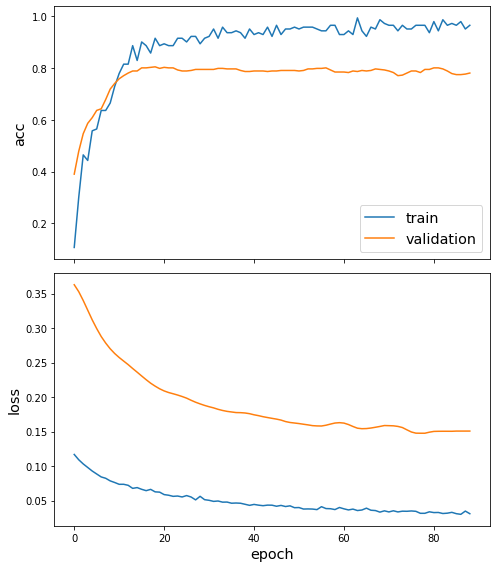

In [19]:
sg.utils.plot_history(history)

In [20]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.75      0.77      0.76       114
    Genetic_Algorithms       0.86      0.88      0.87       156
       Neural_Networks       0.79      0.72      0.75       290
 Probabilistic_Methods       0.77      0.74      0.76       172
Reinforcement_Learning       0.75      0.79      0.77        85
         Rule_Learning       0.56      0.80      0.66        60
                Theory       0.67      0.66      0.66       123

              accuracy                           0.76      1000
             macro avg       0.74      0.77      0.75      1000
          weighted avg       0.76      0.76      0.76      1000



In [21]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3])

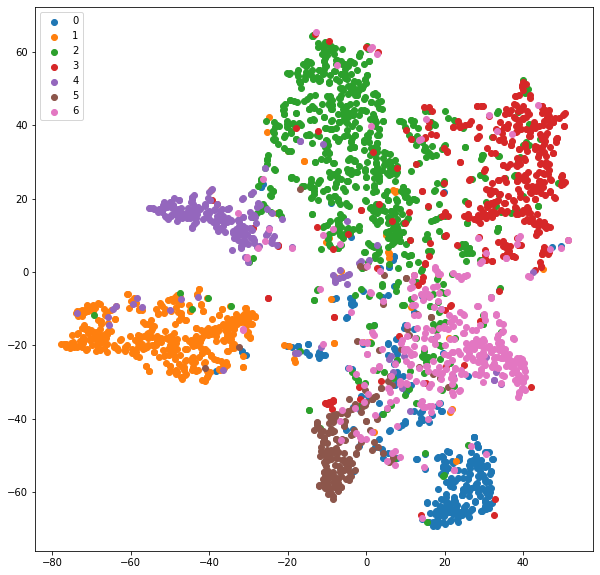

In [22]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)